# Comet MLfrom comet_ml import Experiment

In [1]:
# from comet_ml import Experiment

# # Create an experiment with your api key
# experiment = Experiment(
#     api_key="HeNPARP7EmQTxxVRpewzuqm8b",
#     project_name="face-normal-liveness",
#     workspace="ahmadirfaan",
# )

In [2]:
# hyper_params = {
#     "input_size": 224,
#     "num_classes": 2,
#     "batch_size": 32,
#     "learning_rate": 2e-4
# }

In [3]:
# experiment.log_parameters(hyper_params)

# Import Library

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [5]:
import torch
from torch import nn, optim
from jcopdl.callback import Callback, set_config

import PIL

import os

# device = torch.device('cuda:0')
device = torch.device("cuda:7" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=7)

# Dataset and Dataloader

In [6]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

In [7]:
class BoneAgeDataset(torch.utils.data.Dataset):
    def __init__(self, csv_path, images_folder, transform = None):
        self.df = pd.read_csv(csv_path)
        self.images_folder = images_folder
        self.transform = transform

    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        filename = str(self.df.iloc[index].id)+".jpg"
        label = torch.from_numpy(np.asarray([self.df.iloc[index].boneage]))
        image = PIL.Image.open(os.path.join(self.images_folder, filename))
        image = image.convert('RGB')
        if self.transform is not None:
            image = self.transform(image)
        return image.float(), label.float()

In [8]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    normalize,
])

In [9]:
bs = 64

data_train = BoneAgeDataset("boneage-training-dataset-segmented-4.csv", "../bone-age/boneage-training-dataset/boneage-training-dataset-segmented", transform)

# Split into Train Val
random_seed = 42
torch.manual_seed(random_seed)
val_size = int(len(data_train) * 0.2)
train_size = len(data_train) - (val_size)

train_set, val_set = random_split(
    data_train,
    [train_size, val_size]
)

trainloader = DataLoader(train_set, batch_size=bs)
valloader = DataLoader(val_set, batch_size=bs)

In [10]:
len(train_set), len(val_set)

(48606, 12151)

# Architecture and Config

In [11]:
import torch
from torch import nn
import timm

class BoneAgeModel(nn.Module):
    def __init__(self, pretrained=True):
        super(BoneAgeModel, self).__init__()
        self.backbone = timm.create_model('vit_base_patch16_224', pretrained=pretrained)
        self.n_features = self.backbone.head.in_features
        self.backbone.reset_classifier(0)
        self.fc = nn.Linear(self.n_features, 1)
        
    def freeze(self):
        for param in self.backbone.parameters():
            param.requires_grad = False # Freezing Weight
    
    def unfreeze(self):
        for param in self.backbone.parameters():
            param.requires_grad = True # Unfreezing Weight

    def forward(self, images):
        features = self.backbone(images)              # features = (bs, embedding_size)
        output = self.fc(features)                    # outputs  = (bs, num_classes)
        return output
    
model = BoneAgeModel()
model.to(device)
model.unfreeze()

# Training

In [12]:
from torch.optim import lr_scheduler
from sklearn.metrics import mean_squared_error

In [13]:
# criterion = nn.MSELoss()
def criterion(outputs, targets):
    return torch.sqrt(nn.MSELoss()(outputs.view(-1), targets.view(-1)))
# criterion = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(model.parameters(), lr=1e-4, momentum=0.9)
scheduler = lr_scheduler.CosineAnnealingLR(optimizer,T_max=100, eta_min=1e-6)
# callback = Callback(model, early_stop_patience=4, outdir="model")

In [14]:
def train_one_epoch(model, optimizer, scheduler, dataloader, device, epoch):
    model.train()
    scaler = amp.GradScaler()
    
    dataset_size = 0
    running_loss = 0.0
    
    bar = tqdm(enumerate(dataloader), total=len(dataloader))
    for step, (images, targets) in bar:         
        images = images.to(device, dtype=torch.float)
        targets = targets.to(device, dtype=torch.float)
        
        batch_size = images.size(0)
        
        with amp.autocast(enabled=True):
            outputs = model(images)
            loss = criterion(outputs, targets)
            loss = loss / 1
            
        scaler.scale(loss).backward()
    
        if (step + 1) % 1 == 0:
            scaler.step(optimizer)
            scaler.update()

            # zero the parameter gradients
            optimizer.zero_grad()

            if scheduler is not None:
                scheduler.step()
                
        running_loss += (loss.item() * batch_size)
        dataset_size += batch_size
        
        epoch_loss = running_loss / dataset_size
        
        bar.set_postfix(Epoch=epoch, Train_Loss=epoch_loss,
                        LR=optimizer.param_groups[0]['lr'])
    gc.collect()
    
    return epoch_loss

In [15]:
def smape(A, F):
    return 100/len(A) * np.sum(2 * np.abs(F - A) / (np.abs(A) + np.abs(F)))

In [16]:
@torch.no_grad()
def valid_one_epoch(model, dataloader, device, epoch):
    model.eval()
    
    dataset_size = 0
    running_loss = 0.0
    
    TARGETS = []
    PREDS = []
    
    bar = tqdm(enumerate(dataloader), total=len(dataloader))
    for step, (images, targets) in bar:        
        images = images.to(device, dtype=torch.float)
        targets = targets.to(device, dtype=torch.float)
        
        batch_size = images.size(0)
        
        outputs = model(images)
        loss = criterion(outputs, targets)
        
        running_loss += (loss.item() * batch_size)
        dataset_size += batch_size
        
        epoch_loss = running_loss / dataset_size
        
        PREDS.append(outputs.view(-1).cpu().detach().numpy())
        TARGETS.append(targets.view(-1).cpu().detach().numpy())
        
        bar.set_postfix(Epoch=epoch, Valid_Loss=epoch_loss,
                        LR=optimizer.param_groups[0]['lr'])   
    
    TARGETS = np.concatenate(TARGETS)
    PREDS = np.concatenate(PREDS)
    val_rmse = mean_squared_error(TARGETS, PREDS, squared=False)
    gc.collect()
    
    val_error = np.abs(PREDS - TARGETS).sum().data    
    val_mae = np.mean(np.abs(TARGETS - PREDS))
    
    val_smape = np.mean(2.0 * np.abs(TARGETS - PREDS) / ((np.abs(TARGETS) + np.abs(PREDS)) +1e-10 ))
    
    return epoch_loss, val_rmse, val_mae, val_smape

In [17]:
import time
import copy
from collections import defaultdict
import gc
from torch.cuda import amp
from tqdm import tqdm

In [18]:
from colorama import Fore, Back, Style
c_ = Fore.CYAN
sr_ = Style.RESET_ALL

In [19]:
def run_training(model, optimizer, scheduler, device, num_epochs):
    
    if torch.cuda.is_available():
        print("[INFO] Using GPU: {}\n".format(torch.cuda.get_device_name()))
    
    start = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_epoch_rmse = np.inf
    history = defaultdict(list)
    
    for epoch in range(1, num_epochs + 1): 
        gc.collect()
        train_epoch_loss = train_one_epoch(model, optimizer, scheduler, 
                                           dataloader=trainloader, 
                                           device=device, epoch=epoch)
        
        val_epoch_loss, val_epoch_rmse, val_epoch_mae, val_epoch_smape = valid_one_epoch(model, valloader, 
                                                         device=device, 
                                                         epoch=epoch)
    
        history['Train Loss'].append(train_epoch_loss)
        history['Valid Loss'].append(val_epoch_loss)
        history['Valid RMSE'].append(val_epoch_rmse)
        history['Valid MAE'].append(val_epoch_mae)
        history['Valid SMAPE'].append(val_epoch_smape)
        
        print(f'Valid RMSE: {val_epoch_rmse}')
        print(f'Valid MAE: {val_epoch_mae}')
        print(f'Valid SMAPE: {val_epoch_smape}')
        
        if val_epoch_rmse <= best_epoch_rmse:
            print(f"{c_}Validation Loss Improved ({best_epoch_rmse} ---> {val_epoch_rmse})")
            best_epoch_rmse = val_epoch_rmse
            best_model_wts = copy.deepcopy(model.state_dict())
            PATH = "Model-3/RMSE{:.4f}_epoch{:.0f}.bin".format(best_epoch_rmse, epoch)
            torch.save(model.state_dict(), PATH)
            
        print()
    
    end = time.time()
    time_elapsed = end - start
    print('Training complete in {:.0f}h {:.0f}m {:.0f}s'.format(
        time_elapsed // 3600, (time_elapsed % 3600) // 60, (time_elapsed % 3600) % 60))
    print("Best RMSE: {:.4f}".format(best_epoch_rmse))
    
    # load best model weights
    model.load_state_dict(best_model_wts)
    
    return model, history

In [20]:
model, history = run_training(model, optimizer, scheduler,
                              device=device,
                              num_epochs=100)

[INFO] Using GPU: A100-SXM4-40GB



  0%|          | 0/760 [00:00<?, ?it/s]/opt/conda/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:129: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "
100%|██████████| 190/190 [00:30<00:00,  6.20it/s, Epoch=1, LR=6.58e-5, Valid_Loss=21.1]


Valid RMSE: 21.311904907226562
Valid MAE: 16.316715240478516
Valid SMAPE: 0.1445520520210266
Validation Loss Improved (inf ---> 21.311904907226562)



100%|██████████| 190/190 [00:31<00:00,  6.08it/s, Epoch=2, LR=1.05e-5, Valid_Loss=19.3]


Valid RMSE: 19.40308380126953
Valid MAE: 15.052751541137695
Valid SMAPE: 0.1335562914609909
Validation Loss Improved (21.311904907226562 ---> 19.40308380126953)



100%|██████████| 190/190 [00:31<00:00,  6.07it/s, Epoch=3, LR=1.05e-5, Valid_Loss=18.9]


Valid RMSE: 19.064210891723633
Valid MAE: 14.700906753540039
Valid SMAPE: 0.13058814406394958
Validation Loss Improved (19.40308380126953 ---> 19.064210891723633)



100%|██████████| 190/190 [00:31<00:00,  6.05it/s, Epoch=4, LR=6.58e-5, Valid_Loss=20.4]


Valid RMSE: 20.51940155029297
Valid MAE: 15.523099899291992
Valid SMAPE: 0.13758639991283417



100%|██████████| 190/190 [00:32<00:00,  5.76it/s, Epoch=5, LR=0.0001, Valid_Loss=19.7]


Valid RMSE: 19.842145919799805
Valid MAE: 15.244919776916504
Valid SMAPE: 0.13481198251247406



100%|██████████| 190/190 [00:34<00:00,  5.45it/s, Epoch=6, LR=6.58e-5, Valid_Loss=18.4]


Valid RMSE: 18.516138076782227
Valid MAE: 14.245967864990234
Valid SMAPE: 0.12551404535770416
Validation Loss Improved (19.064210891723633 ---> 18.516138076782227)



100%|██████████| 190/190 [00:32<00:00,  5.80it/s, Epoch=7, LR=1.05e-5, Valid_Loss=18]  


Valid RMSE: 18.171186447143555
Valid MAE: 13.850129127502441
Valid SMAPE: 0.12262841314077377
Validation Loss Improved (18.516138076782227 ---> 18.171186447143555)



100%|██████████| 190/190 [00:33<00:00,  5.69it/s, Epoch=8, LR=1.05e-5, Valid_Loss=17.9]


Valid RMSE: 18.016361236572266
Valid MAE: 13.850198745727539
Valid SMAPE: 0.12286096066236496
Validation Loss Improved (18.171186447143555 ---> 18.016361236572266)



100%|██████████| 190/190 [00:32<00:00,  5.77it/s, Epoch=9, LR=6.58e-5, Valid_Loss=18.5]


Valid RMSE: 18.6439151763916
Valid MAE: 14.421266555786133
Valid SMAPE: 0.12836818397045135



100%|██████████| 190/190 [00:35<00:00,  5.32it/s, Epoch=10, LR=0.0001, Valid_Loss=18.3]


Valid RMSE: 18.393260955810547
Valid MAE: 13.965336799621582
Valid SMAPE: 0.12410516291856766



100%|██████████| 190/190 [00:34<00:00,  5.53it/s, Epoch=11, LR=6.58e-5, Valid_Loss=17.3]


Valid RMSE: 17.412683486938477
Valid MAE: 13.282353401184082
Valid SMAPE: 0.1184317097067833
Validation Loss Improved (18.016361236572266 ---> 17.412683486938477)



100%|██████████| 190/190 [00:31<00:00,  6.06it/s, Epoch=12, LR=1.05e-5, Valid_Loss=17.2]


Valid RMSE: 17.299848556518555
Valid MAE: 13.325058937072754
Valid SMAPE: 0.11825890094041824
Validation Loss Improved (17.412683486938477 ---> 17.299848556518555)



100%|██████████| 190/190 [00:31<00:00,  6.11it/s, Epoch=13, LR=1.05e-5, Valid_Loss=16.9]


Valid RMSE: 17.062068939208984
Valid MAE: 13.07465648651123
Valid SMAPE: 0.1164398267865181
Validation Loss Improved (17.299848556518555 ---> 17.062068939208984)



100%|██████████| 190/190 [00:32<00:00,  5.80it/s, Epoch=14, LR=6.58e-5, Valid_Loss=18.3]


Valid RMSE: 18.418922424316406
Valid MAE: 14.242186546325684
Valid SMAPE: 0.1251816302537918



100%|██████████| 190/190 [00:31<00:00,  6.10it/s, Epoch=15, LR=0.0001, Valid_Loss=17.8]


Valid RMSE: 17.970027923583984
Valid MAE: 13.638835906982422
Valid SMAPE: 0.12097764760255814



100%|██████████| 190/190 [00:32<00:00,  5.89it/s, Epoch=16, LR=6.58e-5, Valid_Loss=17.1]


Valid RMSE: 17.282197952270508
Valid MAE: 13.28808879852295
Valid SMAPE: 0.11851288378238678



100%|██████████| 190/190 [00:33<00:00,  5.59it/s, Epoch=17, LR=1.05e-5, Valid_Loss=16.8]


Valid RMSE: 16.964038848876953
Valid MAE: 12.951354026794434
Valid SMAPE: 0.11560877412557602
Validation Loss Improved (17.062068939208984 ---> 16.964038848876953)



100%|██████████| 190/190 [00:34<00:00,  5.52it/s, Epoch=18, LR=1.05e-5, Valid_Loss=16.9]


Valid RMSE: 17.061767578125
Valid MAE: 13.047178268432617
Valid SMAPE: 0.11663834750652313



100%|██████████| 190/190 [00:34<00:00,  5.43it/s, Epoch=19, LR=6.58e-5, Valid_Loss=17.7]


Valid RMSE: 17.866575241088867
Valid MAE: 13.699501037597656
Valid SMAPE: 0.12116045504808426



100%|██████████| 190/190 [00:33<00:00,  5.63it/s, Epoch=20, LR=0.0001, Valid_Loss=17.9]


Valid RMSE: 18.015527725219727
Valid MAE: 13.761250495910645
Valid SMAPE: 0.12204861640930176



100%|██████████| 190/190 [00:32<00:00,  5.87it/s, Epoch=21, LR=6.58e-5, Valid_Loss=17]  


Valid RMSE: 17.122297286987305
Valid MAE: 12.983104705810547
Valid SMAPE: 0.11561620980501175



100%|██████████| 190/190 [00:31<00:00,  5.99it/s, Epoch=22, LR=1.05e-5, Valid_Loss=16.5]


Valid RMSE: 16.589675903320312
Valid MAE: 12.705693244934082
Valid SMAPE: 0.11336324363946915
Validation Loss Improved (16.964038848876953 ---> 16.589675903320312)



100%|██████████| 190/190 [00:33<00:00,  5.68it/s, Epoch=23, LR=1.05e-5, Valid_Loss=16.4]


Valid RMSE: 16.569589614868164
Valid MAE: 12.597822189331055
Valid SMAPE: 0.11247789114713669
Validation Loss Improved (16.589675903320312 ---> 16.569589614868164)



100%|██████████| 190/190 [00:34<00:00,  5.48it/s, Epoch=24, LR=6.58e-5, Valid_Loss=18.4]


Valid RMSE: 18.553478240966797
Valid MAE: 14.240196228027344
Valid SMAPE: 0.12708938121795654



100%|██████████| 190/190 [00:30<00:00,  6.16it/s, Epoch=25, LR=0.0001, Valid_Loss=16.9]


Valid RMSE: 17.024913787841797
Valid MAE: 13.006444931030273
Valid SMAPE: 0.11661108583211899



100%|██████████| 190/190 [00:32<00:00,  5.80it/s, Epoch=26, LR=6.58e-5, Valid_Loss=16.9]


Valid RMSE: 17.020526885986328
Valid MAE: 12.968140602111816
Valid SMAPE: 0.11618947982788086



100%|██████████| 190/190 [00:33<00:00,  5.69it/s, Epoch=27, LR=1.05e-5, Valid_Loss=16.3]


Valid RMSE: 16.441030502319336
Valid MAE: 12.641053199768066
Valid SMAPE: 0.11312676966190338
Validation Loss Improved (16.569589614868164 ---> 16.441030502319336)



100%|██████████| 190/190 [00:31<00:00,  6.00it/s, Epoch=28, LR=1.05e-5, Valid_Loss=16.3]


Valid RMSE: 16.464447021484375
Valid MAE: 12.501161575317383
Valid SMAPE: 0.11116582900285721



100%|██████████| 190/190 [00:34<00:00,  5.53it/s, Epoch=29, LR=6.58e-5, Valid_Loss=17.1]


Valid RMSE: 17.29106903076172
Valid MAE: 13.204527854919434
Valid SMAPE: 0.11783220618963242



100%|██████████| 190/190 [00:34<00:00,  5.53it/s, Epoch=30, LR=0.0001, Valid_Loss=17.1]


Valid RMSE: 17.26091766357422
Valid MAE: 13.202972412109375
Valid SMAPE: 0.11712382733821869



100%|██████████| 190/190 [00:31<00:00,  6.02it/s, Epoch=31, LR=6.58e-5, Valid_Loss=16.1]


Valid RMSE: 16.259445190429688
Valid MAE: 12.340522766113281
Valid SMAPE: 0.10994720458984375
Validation Loss Improved (16.441030502319336 ---> 16.259445190429688)



100%|██████████| 190/190 [00:32<00:00,  5.93it/s, Epoch=32, LR=1.05e-5, Valid_Loss=16]  


Valid RMSE: 16.167261123657227
Valid MAE: 12.373896598815918
Valid SMAPE: 0.11035142838954926
Validation Loss Improved (16.259445190429688 ---> 16.167261123657227)



100%|██████████| 190/190 [00:34<00:00,  5.54it/s, Epoch=33, LR=1.05e-5, Valid_Loss=16.4]


Valid RMSE: 16.589862823486328
Valid MAE: 12.559531211853027
Valid SMAPE: 0.1121353879570961



100%|██████████| 190/190 [00:33<00:00,  5.67it/s, Epoch=34, LR=6.58e-5, Valid_Loss=16.8]


Valid RMSE: 16.942197799682617
Valid MAE: 12.917927742004395
Valid SMAPE: 0.11573294550180435



100%|██████████| 190/190 [00:32<00:00,  5.86it/s, Epoch=35, LR=0.0001, Valid_Loss=17]  


Valid RMSE: 17.15070152282715
Valid MAE: 12.891439437866211
Valid SMAPE: 0.11652453988790512



100%|██████████| 190/190 [00:31<00:00,  6.13it/s, Epoch=36, LR=6.58e-5, Valid_Loss=16.4]


Valid RMSE: 16.522716522216797
Valid MAE: 12.547266960144043
Valid SMAPE: 0.11159346252679825



100%|██████████| 190/190 [00:30<00:00,  6.19it/s, Epoch=37, LR=1.05e-5, Valid_Loss=16.2]


Valid RMSE: 16.370956420898438
Valid MAE: 12.309807777404785
Valid SMAPE: 0.11000286042690277



100%|██████████| 190/190 [00:34<00:00,  5.49it/s, Epoch=38, LR=1.05e-5, Valid_Loss=16]  


Valid RMSE: 16.120826721191406
Valid MAE: 12.277522087097168
Valid SMAPE: 0.10938987135887146
Validation Loss Improved (16.167261123657227 ---> 16.120826721191406)



100%|██████████| 190/190 [00:31<00:00,  6.11it/s, Epoch=39, LR=6.58e-5, Valid_Loss=16.9]


Valid RMSE: 17.06868553161621
Valid MAE: 13.065633773803711
Valid SMAPE: 0.11638233065605164



100%|██████████| 190/190 [00:31<00:00,  6.11it/s, Epoch=40, LR=0.0001, Valid_Loss=17]  


Valid RMSE: 17.179641723632812
Valid MAE: 12.95942497253418
Valid SMAPE: 0.1163291335105896



100%|██████████| 190/190 [00:32<00:00,  5.85it/s, Epoch=41, LR=6.58e-5, Valid_Loss=16.1]


Valid RMSE: 16.18701171875
Valid MAE: 12.224623680114746
Valid SMAPE: 0.10923882573843002



100%|██████████| 190/190 [00:33<00:00,  5.74it/s, Epoch=42, LR=1.05e-5, Valid_Loss=15.7]


Valid RMSE: 15.845458030700684
Valid MAE: 12.080764770507812
Valid SMAPE: 0.10762645304203033
Validation Loss Improved (16.120826721191406 ---> 15.845458030700684)



100%|██████████| 190/190 [00:32<00:00,  5.86it/s, Epoch=43, LR=1.05e-5, Valid_Loss=15.9]


Valid RMSE: 15.986711502075195
Valid MAE: 12.169461250305176
Valid SMAPE: 0.10894313454627991



100%|██████████| 190/190 [00:34<00:00,  5.49it/s, Epoch=44, LR=6.58e-5, Valid_Loss=16.2]


Valid RMSE: 16.335046768188477
Valid MAE: 12.398763656616211
Valid SMAPE: 0.11070594936609268



100%|██████████| 190/190 [00:33<00:00,  5.60it/s, Epoch=45, LR=0.0001, Valid_Loss=16.8]


Valid RMSE: 16.927852630615234
Valid MAE: 12.949706077575684
Valid SMAPE: 0.11534703522920609



100%|██████████| 190/190 [00:32<00:00,  5.87it/s, Epoch=46, LR=6.58e-5, Valid_Loss=16.1]


Valid RMSE: 16.261537551879883
Valid MAE: 12.480003356933594
Valid SMAPE: 0.11047138273715973



100%|██████████| 190/190 [00:31<00:00,  5.95it/s, Epoch=47, LR=1.05e-5, Valid_Loss=15.8]


Valid RMSE: 15.901256561279297
Valid MAE: 12.05616569519043
Valid SMAPE: 0.10822989046573639



100%|██████████| 190/190 [00:33<00:00,  5.62it/s, Epoch=48, LR=1.05e-5, Valid_Loss=15.9]


Valid RMSE: 16.035099029541016
Valid MAE: 12.174652099609375
Valid SMAPE: 0.10854937136173248



100%|██████████| 190/190 [00:31<00:00,  6.00it/s, Epoch=49, LR=6.58e-5, Valid_Loss=16.1]


Valid RMSE: 16.206764221191406
Valid MAE: 12.347341537475586
Valid SMAPE: 0.11036314815282822



100%|██████████| 190/190 [00:34<00:00,  5.45it/s, Epoch=50, LR=0.0001, Valid_Loss=15.9]


Valid RMSE: 16.067981719970703
Valid MAE: 12.189940452575684
Valid SMAPE: 0.10916543751955032



100%|██████████| 190/190 [00:35<00:00,  5.33it/s, Epoch=51, LR=6.58e-5, Valid_Loss=16.2]


Valid RMSE: 16.35590362548828
Valid MAE: 12.430594444274902
Valid SMAPE: 0.11112317442893982



100%|██████████| 190/190 [00:37<00:00,  5.10it/s, Epoch=52, LR=1.05e-5, Valid_Loss=15.9]


Valid RMSE: 16.041807174682617
Valid MAE: 12.159425735473633
Valid SMAPE: 0.10858378559350967



100%|██████████| 190/190 [00:33<00:00,  5.69it/s, Epoch=53, LR=1.05e-5, Valid_Loss=15.7]


Valid RMSE: 15.847956657409668
Valid MAE: 11.904629707336426
Valid SMAPE: 0.10687796026468277



100%|██████████| 190/190 [00:33<00:00,  5.60it/s, Epoch=54, LR=6.58e-5, Valid_Loss=16.5]


Valid RMSE: 16.6522216796875
Valid MAE: 12.736763000488281
Valid SMAPE: 0.11261273175477982



100%|██████████| 190/190 [00:36<00:00,  5.26it/s, Epoch=55, LR=0.0001, Valid_Loss=15.9]


Valid RMSE: 16.07370948791504
Valid MAE: 12.168073654174805
Valid SMAPE: 0.10842271149158478



100%|██████████| 190/190 [00:33<00:00,  5.71it/s, Epoch=56, LR=6.58e-5, Valid_Loss=15.7]


Valid RMSE: 15.811132431030273
Valid MAE: 11.924928665161133
Valid SMAPE: 0.1068359985947609
Validation Loss Improved (15.845458030700684 ---> 15.811132431030273)



100%|██████████| 190/190 [00:35<00:00,  5.28it/s, Epoch=57, LR=1.05e-5, Valid_Loss=15.6]


Valid RMSE: 15.739753723144531
Valid MAE: 11.923664093017578
Valid SMAPE: 0.10709531605243683
Validation Loss Improved (15.811132431030273 ---> 15.739753723144531)



100%|██████████| 190/190 [00:37<00:00,  5.08it/s, Epoch=58, LR=1.05e-5, Valid_Loss=15.6]


Valid RMSE: 15.747535705566406
Valid MAE: 11.897521018981934
Valid SMAPE: 0.10648459196090698



100%|██████████| 190/190 [00:36<00:00,  5.24it/s, Epoch=59, LR=6.58e-5, Valid_Loss=16.1]


Valid RMSE: 16.23537826538086
Valid MAE: 12.196133613586426
Valid SMAPE: 0.1088055744767189



100%|██████████| 190/190 [00:33<00:00,  5.60it/s, Epoch=60, LR=0.0001, Valid_Loss=16]  


Valid RMSE: 16.134456634521484
Valid MAE: 12.141922950744629
Valid SMAPE: 0.10871482640504837



100%|██████████| 190/190 [00:34<00:00,  5.44it/s, Epoch=61, LR=6.58e-5, Valid_Loss=15.8]


Valid RMSE: 15.880419731140137
Valid MAE: 12.051331520080566
Valid SMAPE: 0.10773038119077682



100%|██████████| 190/190 [00:34<00:00,  5.43it/s, Epoch=62, LR=1.05e-5, Valid_Loss=15.4]


Valid RMSE: 15.57918643951416
Valid MAE: 11.780211448669434
Valid SMAPE: 0.10547206550836563
Validation Loss Improved (15.739753723144531 ---> 15.57918643951416)



100%|██████████| 190/190 [00:32<00:00,  5.80it/s, Epoch=63, LR=1.05e-5, Valid_Loss=15.6]


Valid RMSE: 15.733708381652832
Valid MAE: 11.914560317993164
Valid SMAPE: 0.1066654846072197



100%|██████████| 190/190 [00:33<00:00,  5.59it/s, Epoch=64, LR=6.58e-5, Valid_Loss=15.8]


Valid RMSE: 15.920869827270508
Valid MAE: 12.04575252532959
Valid SMAPE: 0.10829600691795349



100%|██████████| 190/190 [00:33<00:00,  5.68it/s, Epoch=65, LR=0.0001, Valid_Loss=16]  


Valid RMSE: 16.117523193359375
Valid MAE: 12.247926712036133
Valid SMAPE: 0.10910637676715851



100%|██████████| 190/190 [00:35<00:00,  5.32it/s, Epoch=66, LR=6.58e-5, Valid_Loss=15.4]


Valid RMSE: 15.594023704528809
Valid MAE: 11.717698097229004
Valid SMAPE: 0.10485382378101349



100%|██████████| 190/190 [00:33<00:00,  5.71it/s, Epoch=67, LR=1.05e-5, Valid_Loss=15.3]


Valid RMSE: 15.441465377807617
Valid MAE: 11.621552467346191
Valid SMAPE: 0.10362045466899872
Validation Loss Improved (15.57918643951416 ---> 15.441465377807617)



100%|██████████| 190/190 [00:31<00:00,  6.03it/s, Epoch=68, LR=1.05e-5, Valid_Loss=15.3]


Valid RMSE: 15.424834251403809
Valid MAE: 11.665351867675781
Valid SMAPE: 0.1049596518278122
Validation Loss Improved (15.441465377807617 ---> 15.424834251403809)



100%|██████████| 190/190 [00:35<00:00,  5.40it/s, Epoch=69, LR=6.58e-5, Valid_Loss=15.9]


Valid RMSE: 16.05146026611328
Valid MAE: 12.112326622009277
Valid SMAPE: 0.10830442607402802



100%|██████████| 190/190 [00:31<00:00,  6.10it/s, Epoch=70, LR=0.0001, Valid_Loss=16.4]


Valid RMSE: 16.54379653930664
Valid MAE: 12.545384407043457
Valid SMAPE: 0.11224095523357391



100%|██████████| 190/190 [00:34<00:00,  5.44it/s, Epoch=71, LR=6.58e-5, Valid_Loss=15.6]


Valid RMSE: 15.766560554504395
Valid MAE: 11.853278160095215
Valid SMAPE: 0.10624757409095764



100%|██████████| 190/190 [00:36<00:00,  5.25it/s, Epoch=72, LR=1.05e-5, Valid_Loss=15.4]


Valid RMSE: 15.557721138000488
Valid MAE: 11.607720375061035
Valid SMAPE: 0.1044556125998497



100%|██████████| 190/190 [00:33<00:00,  5.62it/s, Epoch=73, LR=1.05e-5, Valid_Loss=15.5]


Valid RMSE: 15.629366874694824
Valid MAE: 11.795376777648926
Valid SMAPE: 0.1057843416929245



100%|██████████| 190/190 [00:35<00:00,  5.43it/s, Epoch=74, LR=6.58e-5, Valid_Loss=15.8]


Valid RMSE: 15.942354202270508
Valid MAE: 11.987051963806152
Valid SMAPE: 0.10763027518987656



100%|██████████| 190/190 [00:32<00:00,  5.79it/s, Epoch=75, LR=0.0001, Valid_Loss=15.6]


Valid RMSE: 15.724034309387207
Valid MAE: 11.748819351196289
Valid SMAPE: 0.10510712116956711



100%|██████████| 190/190 [00:31<00:00,  6.10it/s, Epoch=76, LR=6.58e-5, Valid_Loss=15.5]


Valid RMSE: 15.613974571228027
Valid MAE: 11.730494499206543
Valid SMAPE: 0.10579701513051987



100%|██████████| 190/190 [00:32<00:00,  5.87it/s, Epoch=77, LR=1.05e-5, Valid_Loss=15.2]


Valid RMSE: 15.357272148132324
Valid MAE: 11.48137378692627
Valid SMAPE: 0.10263112187385559
Validation Loss Improved (15.424834251403809 ---> 15.357272148132324)



100%|██████████| 190/190 [00:32<00:00,  5.76it/s, Epoch=78, LR=1.05e-5, Valid_Loss=15.2]


Valid RMSE: 15.364477157592773
Valid MAE: 11.53883171081543
Valid SMAPE: 0.10416848212480545



100%|██████████| 190/190 [00:32<00:00,  5.85it/s, Epoch=79, LR=6.58e-5, Valid_Loss=16]  


Valid RMSE: 16.087858200073242
Valid MAE: 12.023835182189941
Valid SMAPE: 0.10785787552595139



100%|██████████| 190/190 [00:34<00:00,  5.52it/s, Epoch=80, LR=0.0001, Valid_Loss=15.4]


Valid RMSE: 15.572314262390137
Valid MAE: 11.708189010620117
Valid SMAPE: 0.10471794009208679



100%|██████████| 190/190 [00:36<00:00,  5.19it/s, Epoch=81, LR=6.58e-5, Valid_Loss=15.4]


Valid RMSE: 15.615163803100586
Valid MAE: 11.610475540161133
Valid SMAPE: 0.10425027459859848



100%|██████████| 190/190 [00:34<00:00,  5.47it/s, Epoch=82, LR=1.05e-5, Valid_Loss=15.3]


Valid RMSE: 15.395221710205078
Valid MAE: 11.494241714477539
Valid SMAPE: 0.10285186022520065



100%|██████████| 190/190 [00:32<00:00,  5.92it/s, Epoch=83, LR=1.05e-5, Valid_Loss=15.3]


Valid RMSE: 15.455544471740723
Valid MAE: 11.557332992553711
Valid SMAPE: 0.1037972941994667



100%|██████████| 190/190 [00:34<00:00,  5.45it/s, Epoch=84, LR=6.58e-5, Valid_Loss=15.8]


Valid RMSE: 15.898917198181152
Valid MAE: 11.851712226867676
Valid SMAPE: 0.10558239370584488



100%|██████████| 190/190 [00:33<00:00,  5.72it/s, Epoch=85, LR=0.0001, Valid_Loss=15.9]


Valid RMSE: 16.066225051879883
Valid MAE: 12.000868797302246
Valid SMAPE: 0.10774699598550797



100%|██████████| 190/190 [00:33<00:00,  5.68it/s, Epoch=86, LR=6.58e-5, Valid_Loss=15]  


Valid RMSE: 15.164511680603027
Valid MAE: 11.307765007019043
Valid SMAPE: 0.10136754810810089
Validation Loss Improved (15.357272148132324 ---> 15.164511680603027)



100%|██████████| 190/190 [00:37<00:00,  5.10it/s, Epoch=87, LR=1.05e-5, Valid_Loss=15.4]


Valid RMSE: 15.549516677856445
Valid MAE: 11.581466674804688
Valid SMAPE: 0.10407479107379913



100%|██████████| 190/190 [00:33<00:00,  5.68it/s, Epoch=88, LR=1.05e-5, Valid_Loss=15.3]


Valid RMSE: 15.438956260681152
Valid MAE: 11.474428176879883
Valid SMAPE: 0.10280022025108337



100%|██████████| 190/190 [00:31<00:00,  6.09it/s, Epoch=89, LR=6.58e-5, Valid_Loss=15.8]


Valid RMSE: 15.948448181152344
Valid MAE: 11.858813285827637
Valid SMAPE: 0.10642556846141815



100%|██████████| 190/190 [00:32<00:00,  5.80it/s, Epoch=90, LR=0.0001, Valid_Loss=15.3]


Valid RMSE: 15.445319175720215
Valid MAE: 11.609463691711426
Valid SMAPE: 0.10398299247026443



100%|██████████| 190/190 [00:32<00:00,  5.92it/s, Epoch=91, LR=6.58e-5, Valid_Loss=15.2]


Valid RMSE: 15.3163480758667
Valid MAE: 11.438315391540527
Valid SMAPE: 0.10283572226762772



100%|██████████| 190/190 [00:34<00:00,  5.52it/s, Epoch=92, LR=1.05e-5, Valid_Loss=15.1]


Valid RMSE: 15.260931968688965
Valid MAE: 11.38818073272705
Valid SMAPE: 0.10217375308275223



100%|██████████| 190/190 [00:32<00:00,  5.87it/s, Epoch=93, LR=1.05e-5, Valid_Loss=15.3]


Valid RMSE: 15.485418319702148
Valid MAE: 11.483895301818848
Valid SMAPE: 0.1032767966389656



100%|██████████| 190/190 [00:31<00:00,  6.11it/s, Epoch=94, LR=6.58e-5, Valid_Loss=15.3]


Valid RMSE: 15.464128494262695
Valid MAE: 11.619293212890625
Valid SMAPE: 0.10390916466712952



100%|██████████| 190/190 [00:33<00:00,  5.75it/s, Epoch=95, LR=0.0001, Valid_Loss=15.6]


Valid RMSE: 15.712072372436523
Valid MAE: 11.673860549926758
Valid SMAPE: 0.10612265020608902



100%|██████████| 190/190 [00:34<00:00,  5.48it/s, Epoch=96, LR=6.58e-5, Valid_Loss=15.3]


Valid RMSE: 15.445056915283203
Valid MAE: 11.486616134643555
Valid SMAPE: 0.10312087088823318



100%|██████████| 190/190 [00:35<00:00,  5.37it/s, Epoch=97, LR=1.05e-5, Valid_Loss=14.9]


Valid RMSE: 15.00545597076416
Valid MAE: 11.281682014465332
Valid SMAPE: 0.10171014070510864
Validation Loss Improved (15.164511680603027 ---> 15.00545597076416)



100%|██████████| 190/190 [00:35<00:00,  5.35it/s, Epoch=98, LR=1.05e-5, Valid_Loss=15.3]


Valid RMSE: 15.40982437133789
Valid MAE: 11.431859970092773
Valid SMAPE: 0.10311758518218994



100%|██████████| 190/190 [00:35<00:00,  5.41it/s, Epoch=99, LR=6.58e-5, Valid_Loss=15.3]


Valid RMSE: 15.46879768371582
Valid MAE: 11.5709228515625
Valid SMAPE: 0.10374176502227783



100%|██████████| 190/190 [00:34<00:00,  5.46it/s, Epoch=100, LR=0.0001, Valid_Loss=15.3]


Valid RMSE: 15.504121780395508
Valid MAE: 11.584440231323242
Valid SMAPE: 0.10421078652143478

Training complete in 7h 0m 19s
Best RMSE: 15.0055


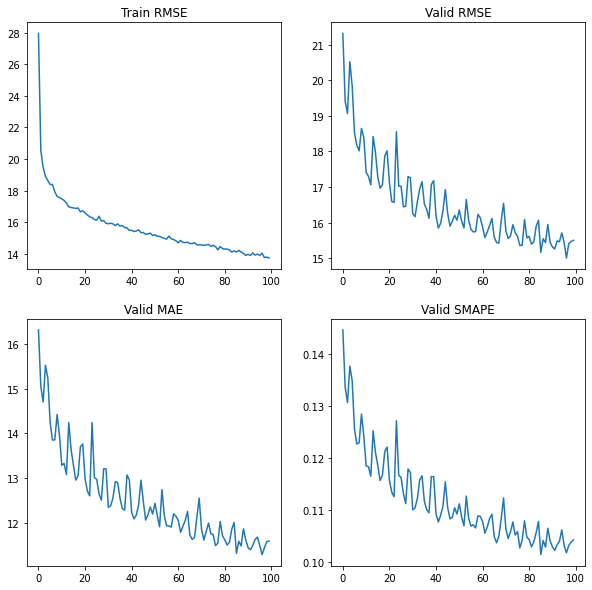

In [21]:
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

axs[0, 0].plot(history['Train Loss'])
axs[0, 0].title.set_text('Train RMSE')
axs[0, 1].plot(history['Valid RMSE'])
axs[0, 1].title.set_text('Valid RMSE')
axs[1, 0].plot(history['Valid MAE'])
axs[1, 0].title.set_text('Valid MAE')
axs[1, 1].plot(history['Valid SMAPE'])
axs[1, 1].title.set_text('Valid SMAPE')

In [22]:
test

NameError: name 'test' is not defined